In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from einops import rearrange, repeat, einsum

In [2]:
class MambaRMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = (
            x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight
        )
        return output


class MinimalMamba(nn.Module):
    def __init__(self, d_model, d_inner, dt_rank, d_state, bias=True):
        """A single Mamba block, as described in Figure 3 in Section 3.4 in the Mamba paper [1]."""
        # Mitchell's note: d_model is the dimensionality of the input and output (the embedding)
        # d_inner is the dimensionality of the input to the SSM
        # d_state is the dimensionality of the state space for each input
        super().__init__()
        self.d_inner = d_inner
        self.d_model = d_model
        self.dt_rank = dt_rank
        self.d_state = d_state

        self.in_proj = nn.Linear(d_model, d_inner * 2, bias=bias)

        # x_proj takes in `x` and outputs the input-specific Δ, B, C
        self.x_proj = nn.Linear(d_inner, dt_rank + d_state * 2, bias=False)

        # dt_proj projects Δ from dt_rank to d_in
        self.dt_proj = nn.Linear(dt_rank, d_inner, bias=True)

        A = repeat(torch.arange(1, d_state + 1), "n -> d n", d=d_inner)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(d_inner))
        self.out_proj = nn.Linear(d_inner, d_model, bias=bias)
        self.norm = MambaRMSNorm(d_model)

    def forward(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba paper [1].

        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d)

        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311

        """

        (b, l, d) = x.shape
        x_copy = x  # There was a separate class for residual, I deleted that part and added it here.
        x = self.norm(x)
        x_and_res = self.in_proj(x)  # shape (b, l, 2 * d_in)
        (x, res) = x_and_res.split(split_size=[self.d_inner, self.d_inner], dim=-1)

        x = rearrange(x, "b l d_in -> b d_in l")
        x = rearrange(x, "b d_in l -> b l d_in")

        x = F.silu(x)

        y = self.ssm(x)

        y = y * F.silu(res)

        output = self.out_proj(y) + x_copy

        return output, None

    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        Args:
            x: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311

        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)

        A = -torch.exp(self.A_log.float())  # shape (d_in, n)
        D = self.D.float()

        x_dbl = self.x_proj(x)  # (b, l, dt_rank + 2*n)

        (delta, B, C) = x_dbl.split(
            split_size=[self.dt_rank, n, n], dim=-1
        )  # delta: (b, l, dt_rank). B, C: (b, l, n)
        delta = F.softplus(self.dt_proj(delta))  # (b, l, d_in)

        y = self.selective_scan(
            x, delta, A, B, C, D
        )  # This is similar to run_SSM(A, B, C, u) in The Annotated S4 [2]

        return y

    def selective_scan(self, u, delta, A, B, C, D):
        """Does selective scan algorithm. See:
            - Section 2 State Space Models in the Mamba paper [1]
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        This is the classic discrete state space formula:
            x(t + 1) = Ax(t) + Bu(t)
            y(t)     = Cx(t) + Du(t)
        except B and C (and the step size delta, which is used for discretization) are dependent on the input x(t).

        Args:
            u: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)
            delta: shape (b, l, d_in)
            A: shape (d_in, n)
            B: shape (b, l, n)
            C: shape (b, l, n)
            D: shape (d_in,)

        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            selective_scan_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L86
            Note: I refactored some parts out of `selective_scan_ref` out, so the functionality doesn't match exactly.

        """
        (b, l, d_in) = u.shape
        n = A.shape[1]

        # Discretize continuous parameters (A, B)
        # - A is discretized using zero-order hold (ZOH) discretization (see Section 2 Equation 4 in the Mamba paper [1])
        # - B is discretized using a simplified Euler discretization instead of ZOH. From a discussion with authors:
        #   "A is the more important term and the performance doesn't change much with the simplication on B"
        deltaA = torch.exp(einsum(delta, A, "b l d_in, d_in n -> b d_in l n"))
        deltaB_u = einsum(delta, B, u, "b l d_in, b l n, b l d_in -> b d_in l n")

        # Perform selective scan (see scan_SSM() in The Annotated S4 [2])
        x = torch.zeros((b, d_in, n), device=deltaA.device)
        self.hiddens = []
        ys = []
        for i in range(l):
            x = deltaA[:, :, i] * x + deltaB_u[:, :, i]
            self.hiddens.append(x)
            y = einsum(x, C[:, i, :], "b d_in n, b n -> b d_in")
            ys.append(y)
        y = torch.stack(ys, dim=1)  # shape (b, l, d_in)
        self.hiddens = torch.stack(self.hiddens, dim=1)
        y = y + u * D

        return y

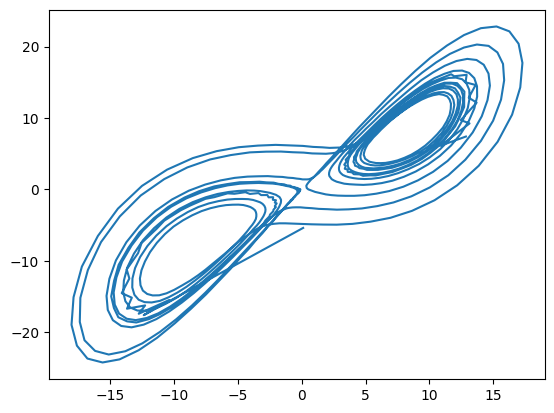

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(1000, resample=True, noise=0.01)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])

In [4]:
model = MinimalMamba(1, 1, 1, 100)

In [5]:
data = torch.tensor(sol[np.newaxis, :, 0:1]).float()
print(data.size())
out, _ = model(data)
out.shape, model.hiddens.shape

torch.Size([1, 1000, 1])


(torch.Size([1, 1000, 1]), torch.Size([1, 1000, 1, 100]))

In [6]:
hidden = model.hiddens.detach().numpy().squeeze()

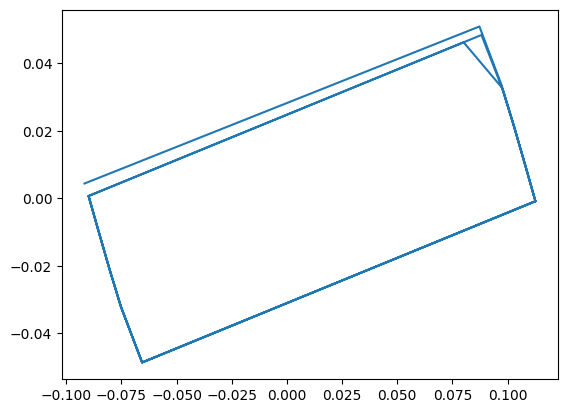

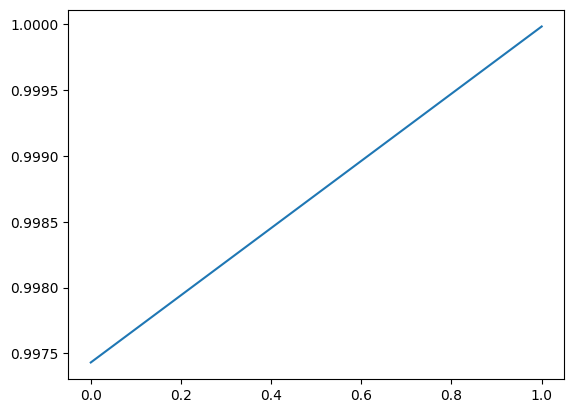

In [7]:
# run pca on the hidden states
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:, 0], hidden_pca[:, 1])
plt.figure()
# plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

(20, 1000, 3) torch.Size([20, 1000, 1])
(20, 1000, 3) torch.Size([20, 1000, 1])


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Training Loss: 0.8979977130889892


  2%|▏         | 1/50 [00:40<33:22, 40.86s/it]

Epoch 0 Validation Loss: 0.8976775497198105
Epoch 1 Training Loss: 0.8433517992496491


  4%|▍         | 2/50 [04:16<1:55:04, 143.85s/it]

Epoch 1 Validation Loss: 0.8356639057397842
Epoch 2 Training Loss: 0.7738828092813492


  6%|▌         | 3/50 [04:57<1:15:41, 96.64s/it] 

Epoch 2 Validation Loss: 0.7612339228391647
Epoch 3 Training Loss: 0.6968897506594658


  8%|▊         | 4/50 [05:21<52:12, 68.09s/it]  

Epoch 3 Validation Loss: 0.6879009008407593
Epoch 4 Training Loss: 0.6503775417804718


 10%|█         | 5/50 [05:44<38:47, 51.73s/it]

Epoch 4 Validation Loss: 0.6666031211614609
Epoch 5 Training Loss: 0.6379929721355438


 12%|█▏        | 6/50 [06:06<30:40, 41.84s/it]

Epoch 5 Validation Loss: 0.6546098411083221
Epoch 6 Training Loss: 0.6264478519558907


 14%|█▍        | 7/50 [06:29<25:32, 35.65s/it]

Epoch 6 Validation Loss: 0.6434987962245942
Epoch 7 Training Loss: 0.6154080212116242


 16%|█▌        | 8/50 [06:53<22:10, 31.68s/it]

Epoch 7 Validation Loss: 0.632720822095871
Epoch 8 Training Loss: 0.6048155814409256


 18%|█▊        | 9/50 [07:15<19:43, 28.87s/it]

Epoch 8 Validation Loss: 0.6220052018761635
Epoch 9 Training Loss: 0.5943506419658661


 20%|██        | 10/50 [07:38<18:00, 27.02s/it]

Epoch 9 Validation Loss: 0.6115412414073944
Epoch 10 Training Loss: 0.5841658368706704


 22%|██▏       | 11/50 [08:01<16:42, 25.70s/it]

Epoch 10 Validation Loss: 0.601361808180809
Epoch 11 Training Loss: 0.5741872966289521


 24%|██▍       | 12/50 [08:24<15:44, 24.86s/it]

Epoch 11 Validation Loss: 0.5916313841938973
Epoch 12 Training Loss: 0.5646235480904579


 26%|██▌       | 13/50 [08:46<14:56, 24.22s/it]

Epoch 12 Validation Loss: 0.5821060538291931
Epoch 13 Training Loss: 0.5554503008723259


 28%|██▊       | 14/50 [09:09<14:15, 23.77s/it]

Epoch 13 Validation Loss: 0.5726427286863327
Epoch 14 Training Loss: 0.5463873773813248


 30%|███       | 15/50 [09:32<13:42, 23.49s/it]

Epoch 14 Validation Loss: 0.5636201947927475
Epoch 15 Training Loss: 0.5376358941197396


 32%|███▏      | 16/50 [09:55<13:11, 23.29s/it]

Epoch 15 Validation Loss: 0.5550469398498535
Epoch 16 Training Loss: 0.529196335375309


 34%|███▍      | 17/50 [10:18<12:42, 23.11s/it]

Epoch 16 Validation Loss: 0.5468929260969162
Epoch 17 Training Loss: 0.521195787191391


 36%|███▌      | 18/50 [10:41<12:20, 23.14s/it]

Epoch 17 Validation Loss: 0.5388650462031365
Epoch 18 Training Loss: 0.5136143833398819


 38%|███▊      | 19/50 [11:04<12:00, 23.23s/it]

Epoch 18 Validation Loss: 0.5308118164539337
Epoch 19 Training Loss: 0.5059082761406899


 40%|████      | 20/50 [11:29<11:54, 23.83s/it]

Epoch 19 Validation Loss: 0.5234875619411469
Epoch 20 Training Loss: 0.4986893132328987


 42%|████▏     | 21/50 [12:13<14:23, 29.77s/it]

Epoch 20 Validation Loss: 0.5165599003434181
Epoch 21 Training Loss: 0.4920358806848526


 44%|████▍     | 22/50 [13:38<21:34, 46.25s/it]

Epoch 21 Validation Loss: 0.5094565644860267
Epoch 22 Training Loss: 0.48522944897413256


 46%|████▌     | 23/50 [14:03<18:01, 40.05s/it]

Epoch 22 Validation Loss: 0.5030692234635353
Epoch 23 Training Loss: 0.47902100533246994


 48%|████▊     | 24/50 [14:33<16:01, 36.97s/it]

Epoch 23 Validation Loss: 0.4967278927564621
Epoch 24 Training Loss: 0.47290346771478653


 50%|█████     | 25/50 [15:29<17:47, 42.70s/it]

Epoch 24 Validation Loss: 0.4908186599612236
Epoch 25 Training Loss: 0.4671508029103279


 52%|█████▏    | 26/50 [16:17<17:44, 44.34s/it]

Epoch 25 Validation Loss: 0.4851406916975975
Epoch 26 Training Loss: 0.46168906390666964


 54%|█████▍    | 27/50 [16:41<14:39, 38.24s/it]

Epoch 26 Validation Loss: 0.47963892966508864
Epoch 27 Training Loss: 0.45649043619632723


 56%|█████▌    | 28/50 [17:05<12:28, 34.00s/it]

Epoch 27 Validation Loss: 0.4743132099509239
Epoch 28 Training Loss: 0.45141551941633223


 58%|█████▊    | 29/50 [17:31<11:02, 31.54s/it]

Epoch 28 Validation Loss: 0.4693837031722069
Epoch 29 Training Loss: 0.4467137962579727


 60%|██████    | 30/50 [18:08<11:00, 33.00s/it]

Epoch 29 Validation Loss: 0.4646208122372627
Epoch 30 Training Loss: 0.4421462908387184


 62%|██████▏   | 31/50 [18:32<09:35, 30.28s/it]

Epoch 30 Validation Loss: 0.4601448729634285
Epoch 31 Training Loss: 0.4377873405814171


 64%|██████▍   | 32/50 [18:59<08:49, 29.44s/it]

Epoch 31 Validation Loss: 0.45603806972503663
Epoch 32 Training Loss: 0.43379528969526293


 66%|██████▌   | 33/50 [19:22<07:47, 27.50s/it]

Epoch 32 Validation Loss: 0.45199991315603255
Epoch 33 Training Loss: 0.42998761087656023


 68%|██████▊   | 34/50 [20:44<11:41, 43.81s/it]

Epoch 33 Validation Loss: 0.4480791226029396
Epoch 34 Training Loss: 0.42618456333875654


 70%|███████   | 35/50 [21:08<09:27, 37.82s/it]

Epoch 34 Validation Loss: 0.4446355998516083
Epoch 35 Training Loss: 0.42286641597747804


 72%|███████▏  | 36/50 [21:32<07:51, 33.70s/it]

Epoch 35 Validation Loss: 0.44107408821582794
Epoch 36 Training Loss: 0.4195250615477562


 74%|███████▍  | 37/50 [21:55<06:36, 30.54s/it]

Epoch 36 Validation Loss: 0.4378398612141609
Epoch 37 Training Loss: 0.41645960360765455


 76%|███████▌  | 38/50 [22:18<05:40, 28.40s/it]

Epoch 37 Validation Loss: 0.4347261130809784
Epoch 38 Training Loss: 0.41347846686840056


 78%|███████▊  | 39/50 [22:42<04:55, 26.87s/it]

Epoch 38 Validation Loss: 0.4318950861692429
Epoch 39 Training Loss: 0.41073891818523406


 80%|████████  | 40/50 [23:38<05:58, 35.83s/it]

Epoch 39 Validation Loss: 0.42917812764644625
Epoch 40 Training Loss: 0.4081371232867241


 82%|████████▏ | 41/50 [24:26<05:53, 39.23s/it]

Epoch 40 Validation Loss: 0.4266204357147217
Epoch 41 Training Loss: 0.4057015284895897


 84%|████████▍ | 42/50 [24:58<04:56, 37.02s/it]

Epoch 41 Validation Loss: 0.42417333275079727
Epoch 42 Training Loss: 0.4034262150526047


 86%|████████▌ | 43/50 [25:42<04:34, 39.20s/it]

Epoch 42 Validation Loss: 0.421810482442379
Epoch 43 Training Loss: 0.4011978268623352


 88%|████████▊ | 44/50 [26:15<03:43, 37.31s/it]

Epoch 43 Validation Loss: 0.41970404237508774
Epoch 44 Training Loss: 0.3991671189665794


 90%|█████████ | 45/50 [26:39<02:47, 33.52s/it]

Epoch 44 Validation Loss: 0.4177105098962784
Epoch 45 Training Loss: 0.3972533896565437


 92%|█████████▏| 46/50 [27:13<02:14, 33.51s/it]

Epoch 45 Validation Loss: 0.41585166603326795
Epoch 46 Training Loss: 0.3954761192202568


 94%|█████████▍| 47/50 [27:48<01:41, 33.95s/it]

Epoch 46 Validation Loss: 0.41408541798591614
Epoch 47 Training Loss: 0.393832765519619


 96%|█████████▌| 48/50 [28:21<01:07, 33.65s/it]

Epoch 47 Validation Loss: 0.41237783432006836
Epoch 48 Training Loss: 0.3922449290752411


 98%|█████████▊| 49/50 [29:19<00:40, 40.89s/it]

Epoch 48 Validation Loss: 0.4108446568250656
Epoch 49 Training Loss: 0.3907996013760567


100%|██████████| 50/50 [30:05<00:00, 36.11s/it]

Epoch 49 Validation Loss: 0.4094105437397957


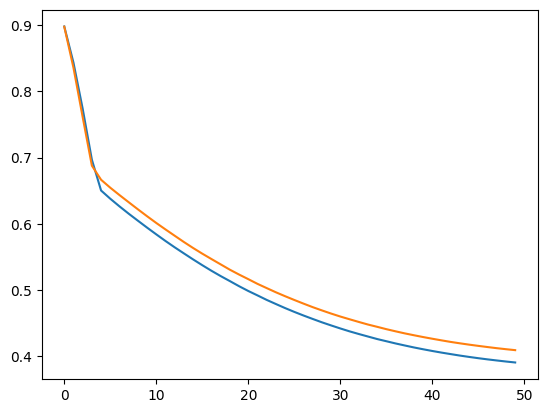

In [8]:
from utils import train, make_dataset
from torch.optim import AdamW

model = MinimalMamba(1, 1, 10, 100)
train_loader, val_loader, train_data, val_data = make_dataset(Lorenz, 1000, 20)

# model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
model, train_loss, val_loss = train(
    model, train_loader, val_loader, 50, 1e-3, AdamW, nn.MSELoss(), "cpu"
)
plt.plot(train_loss)
plt.plot(val_loss)